# Information Retrieval 1#
## Assignment 2: Retrieval models [100 points] ##

In this assignment you will get familiar with basic and advanced information retrieval concepts. You will implement different information retrieval ranking models and evaluate their performance.

We provide you with a Indri index. To query the index, you'll use a Python package ([pyndri](https://github.com/cvangysel/pyndri)) that allows easy access to the underlying document statistics.

For evaluation you'll use the [TREC Eval](https://github.com/usnistgov/trec_eval) utility, provided by the National Institute of Standards and Technology of the United States. TREC Eval is the de facto standard way to compute Information Retrieval measures and is frequently referenced in scientific papers.

This is a **groups-of-three assignment**, the deadline is **Wednesday, January 31st**. Code quality, informative comments and convincing analysis of the results will be considered when grading. Submission should be done through blackboard, questions can be asked on the course [Piazza](piazza.com/university_of_amsterdam/spring2018/52041inr6y/home).

### Technicalities (must-read!) ###

The assignment directory is organized as follows:
   * `./assignment.ipynb` (this file): the description of the assignment.
   * `./index/`: the index we prepared for you.
   * `./ap_88_90/`: directory with ground-truth and evaluation sets:
      * `qrel_test`: test query relevance collection (**test set**).
      * `qrel_validation`: validation query relevance collection (**validation set**).
      * `topics_title`: semicolon-separated file with query identifiers and terms.

You will need the following software packages (tested with Python 3.5 inside [Anaconda](https://conda.io/docs/user-guide/install/index.html)):
   * Python 3.5 and Jupyter
   * Indri + Pyndri (Follow the installation instructions [here](https://github.com/nickvosk/pyndri/blob/master/README.md))
   * gensim [link](https://radimrehurek.com/gensim/install.html)
   * TREC Eval [link](https://github.com/usnistgov/trec_eval)

### TREC Eval primer ###
The TREC Eval utility can be downloaded and compiled as follows:

    git clone https://github.com/usnistgov/trec_eval.git
    cd trec_eval
    make

TREC Eval computes evaluation scores given two files: ground-truth information regarding relevant documents, named *query relevance* or *qrel*, and a ranking of documents for a set of queries, referred to as a *run*. The *qrel* will be supplied by us and should not be changed. For every retrieval model (or combinations thereof) you will generate a run of the top-1000 documents for every query. The format of the *run* file is as follows:

    $query_identifier Q0 $document_identifier $rank_of_document_for_query $query_document_similarity $run_identifier
    
where
   * `$query_identifier` is the unique identifier corresponding to a query (usually this follows a sequential numbering).
   * `Q0` is a legacy field that you can ignore.
   * `$document_identifier` corresponds to the unique identifier of a document (e.g., APXXXXXXX where AP denotes the collection and the Xs correspond to a unique numerical identifier).
   * `$rank_of_document_for_query` denotes the rank of the document for the particular query. This field is ignored by TREC Eval and is only maintained for legacy support. The ranks are computed by TREC Eval itself using the `$query_document_similarity` field (see next). However, it remains good practice to correctly compute this field.
   * `$query_document_similarity` is a score indicating the similarity between query and document where a higher score denotes greater similarity.
   * `$run_identifier` is an identifier of the run. This field is for your own convenience and has no purpose beyond bookkeeping.
   
For example, say we have two queries: `Q1` and `Q2` and we rank three documents (`DOC1`, `DOC2`, `DOC3`). For query `Q1`, we find the following similarity scores `score(Q1, DOC1) = 1.0`, `score(Q1, DOC2) = 0.5`, `score(Q1, DOC3) = 0.75`; and for `Q2`: `score(Q2, DOC1) = -0.1`, `score(Q2, DOC2) = 1.25`, `score(Q1, DOC3) = 0.0`. We can generate run using the following snippet:

In [172]:
import logging
import sys
import os

def write_run(model_name, data, out_f,
              max_objects_per_query=sys.maxsize,
              skip_sorting=False):
    """
    Write a run to an output file.
    Parameters:
        - model_name: identifier of run.
        - data: dictionary mapping topic_id to object_assesments;
            object_assesments is an iterable (list or tuple) of
            (relevance, object_id) pairs.
            The object_assesments iterable is sorted by decreasing order.
        - out_f: output file stream.
        - max_objects_per_query: cut-off for number of objects per query.
    """

    for subject_id, object_assesments in data.items():
        if not object_assesments:
            logging.warning('Received empty ranking for %s; ignoring.',
                            subject_id)

            continue

        # Probe types, to make sure everything goes alright.
        # assert isinstance(object_assesments[0][0], float) or \
        #     isinstance(object_assesments[0][0], np.float32)
        assert isinstance(object_assesments[0][1], str) or \
            isinstance(object_assesments[0][1], bytes)

        if not skip_sorting:
            object_assesments = sorted(object_assesments, reverse=True)

        if max_objects_per_query < sys.maxsize:
            object_assesments = object_assesments[:max_objects_per_query]

        if isinstance(subject_id, bytes):
            subject_id = subject_id.decode('utf8')

        for rank, (relevance, object_id) in enumerate(object_assesments):
            if isinstance(object_id, bytes):
                object_id = object_id.decode('utf8')

            out_f.write(
                '{subject} Q0 {object} {rank} {relevance} '
                '{model_name}\n'.format(
                    subject=subject_id,
                    object=object_id,
                    rank=rank + 1,
                    relevance=relevance,
                    model_name=model_name))
            
# The following writes the run to standard output.
# In your code, you should write the runs to local
# storage in order to pass them to trec_eval.
write_run(
    model_name='example',
    data={
        'Q1': ((1.0, 'DOC1'), (0.5, 'DOC2'), (0.75, 'DOC3')),
        'Q2': ((-0.1, 'DOC1'), (1.25, 'DOC2'), (0.0, 'DOC3')),
    },
    out_f=sys.stdout,
    max_objects_per_query=1000)

Q1 Q0 DOC1 1 1.0 example
Q1 Q0 DOC3 2 0.75 example
Q1 Q0 DOC2 3 0.5 example
Q2 Q0 DOC2 1 1.25 example
Q2 Q0 DOC3 2 0.0 example
Q2 Q0 DOC1 3 -0.1 example


In [173]:
#!/usr/bin/env python
import subprocess
from collections import defaultdict 

# Run evaluation bash script...
# subprocess.call(["./assignment_evals.sh"])


# ... And retrieve again
eval_data = defaultdict(list)

for file in os.listdir("run"):
    print(file)
    if file == "TF-IDF.txt":
        with open("run/" + file) as file:
            content = [line.strip().split() for line in file.readlines()]
#             print(content)
            for metric, query, score in content:
                eval_data[metric].append((query,score))


absolute_0.5_val_queries_len_C_is_num_words.run
jelinek_0.5_val_queries_len_C_is_num_words.txt
jelinek_0.1_val_queries_len_C_is_num_words.run
jelinek_0.1_val_queries_len_C_is_num_words.txt
BM25_testqueries.txt
BM25_testqueries.run
jelinek_0.9_val_queries_len_C_is_num_words.run
jelinek_0.9_val_queries_len_C_is_num_words.txt
dirichlet_1500_val_queries_len_C_is_num_words.txt
absolute_0.9_val_queries_len_C_is_num_words.txt
dirichlet_1000_val_queries_len_C_is_num_words.txt
absolute_0.9_val_queries_len_C_is_num_words.run
dirichlet_500_val_queries_len_C_is_num_words.run
jelinek_0.5_val_queries_len_C_is_num_words.run
dirichlet_1000_val_queries_len_C_is_num_words.run
TF-IDF.txt
absolute_0.1_val_queries_len_C_is_num_words.txt
dirichlet_1500_val_queries_len_C_is_num_words.run
dirichlet_500_val_queries_len_C_is_num_words.txt
absolute_0.1_val_queries_len_C_is_num_words.run
absolute_0.5_val_queries_len_C_is_num_words.txt
run old
TF-IDF.run


In [174]:
eval_data

defaultdict(list,
            {'P_5': [('100', '0.2000'),
              ('101', '0.4000'),
              ('102', '0.2000'),
              ('104', '0.4000'),
              ('105', '0.0000'),
              ('106', '0.0000'),
              ('107', '0.2000'),
              ('108', '0.0000'),
              ('109', '0.0000'),
              ('110', '0.2000'),
              ('112', '0.2000'),
              ('113', '0.0000'),
              ('115', '0.2000'),
              ('116', '0.8000'),
              ('117', '0.2000'),
              ('118', '0.2000'),
              ('119', '0.0000'),
              ('121', '0.4000'),
              ('122', '0.0000'),
              ('124', '0.6000'),
              ('125', '0.2000'),
              ('126', '0.6000'),
              ('127', '0.0000'),
              ('128', '0.4000'),
              ('129', '0.0000'),
              ('130', '0.8000'),
              ('131', '0.0000'),
              ('132', '0.8000'),
              ('133', '0.8000'),
              ('13

Now, imagine that we know that `DOC1` is relevant and `DOC3` is non-relevant for `Q1`. In addition, for `Q2` we only know of the relevance of `DOC3`. The query relevance file looks like:

    Q1 0 DOC1 1
    Q1 0 DOC3 0
    Q2 0 DOC3 1
    
We store the run and qrel in files `example.run` and `example.qrel` respectively on disk. We can now use TREC Eval to compute evaluation measures. In this example, we're only interested in Mean Average Precision and we'll only show this below for brevity. However, TREC Eval outputs much more information such as NDCG, recall, precision, etc.
    $ ./trec_eval/trec_eval -q ap_88_89/qrel_test ap_88_89/TF-IDF.run | grep -E "^map\s"
    $ trec_eval -m all_trec -q example.qrel example.run | grep -E "^map\s"
    > map                   	Q1	1.0000
    > map                   	Q2	0.5000
    > map                   	all	0.7500
    
Now that we've discussed the output format of rankings and how you can compute evaluation measures from these rankings, we'll now proceed with an overview of the indexing framework you'll use.

### Pyndri primer ###
For this assignment you will use [Pyndri](https://github.com/cvangysel/pyndri) [[1](https://arxiv.org/abs/1701.00749)], a python interface for [Indri](https://www.lemurproject.org/indri.php). We have indexed the document collection and you can query the index using Pyndri. We will start by giving you some examples of what Pyndri can do:

First we read the document collection index with Pyndri:

In [175]:
import pyndri

index = pyndri.Index('index/')

The loaded index can be used to access a collection of documents in an easy manner. We'll give you some examples to get some idea of what it can do, it is up to you to figure out how to use it for the remainder of the assignment.

First let's look at the number of documents, since Pyndri indexes the documents using incremental identifiers we can simply take the lowest index and the maximum document and consider the difference:

In [176]:
print(index.maximum_document())
print(index.document_base())

print("There are %d documents in this collection." % (index.maximum_document() - index.document_base()))

164598
1
There are 164597 documents in this collection.


Let's take the first document out of the collection and take a look at it:

In [177]:
# APXXXXXXXXX corresponds to the unique identifier of a document:
# e.g., APXXXXXXX where AP denotes the collection and the Xs correspond to a unique numerical identifier.

example_document = index.document(1)
print(example_document)
print(len(example_document[1]))

('AP890425-0001', (1360, 192, 363, 0, 880, 0, 200, 0, 894, 412, 92160, 3, 192, 0, 363, 34, 1441, 0, 174134, 0, 200, 0, 894, 412, 2652, 0, 810, 107, 49, 4903, 420, 0, 1, 48, 35, 489, 0, 35, 687, 192, 243, 0, 249311, 1877, 0, 1651, 1174, 0, 2701, 117, 412, 0, 810, 391, 245233, 1225, 5838, 16, 0, 233156, 3496, 0, 393, 17, 0, 2435, 4819, 930, 0, 0, 200, 0, 894, 0, 22, 398, 145, 0, 3, 271, 115, 0, 1176, 2777, 292, 0, 725, 192, 0, 0, 50046, 0, 1901, 1130, 0, 192, 0, 408, 0, 243779, 0, 0, 553, 192, 0, 363, 0, 3747, 0, 0, 0, 0, 1176, 0, 1239, 0, 0, 1115, 17, 0, 0, 585, 192, 1963, 0, 0, 412, 54356, 0, 773, 0, 0, 0, 192, 0, 0, 1130, 0, 363, 0, 545, 192, 0, 1174, 1901, 1130, 0, 4, 398, 145, 39, 0, 577, 0, 355, 0, 491, 0, 6025, 0, 0, 193156, 88, 34, 437, 0, 0, 1852, 0, 828, 0, 1588, 0, 0, 0, 2615, 0, 0, 107, 49, 420, 0, 0, 190, 7, 714, 2701, 0, 237, 192, 157, 0, 412, 34, 437, 0, 0, 200, 6025, 26, 0, 0, 0, 0, 363, 0, 22, 398, 145, 0, 200, 638, 126222, 6018, 0, 880, 0, 0, 161, 0, 0, 319, 894, 2701, 

Here we see a document consists of two things, a string representing the external document identifier and an integer list representing the identifiers of words that make up the document. Pyndri uses integer representations for words or terms, thus a token_id is an integer that represents a word whereas the token is the actual text of the word/term. Every id has a unique token and vice versa with the exception of stop words: words so common that there are uninformative, all of these receive the zero id.

To see what some ids and their matching tokens we take a look at the dictionary of the index:

In [178]:
token2id, id2token, _ = index.get_dictionary()
print(list(id2token.items())[:15])
print(len(id2token))

[(1, 'new'), (2, 'percent'), (3, 'two'), (4, '1'), (5, 'people'), (6, 'million'), (7, '000'), (8, 'government'), (9, 'president'), (10, 'years'), (11, 'state'), (12, '2'), (13, 'states'), (14, 'three'), (15, 'time')]
267318


Using this dictionary we can see the tokens for the (non-stop) words in our example document:

In [179]:
print([id2token[word_id] for word_id in example_document[1] if word_id > 0])

['52', 'students', 'arrested', 'takeover', 'university', 'massachusetts', 'building', 'fifty', 'two', 'students', 'arrested', 'tuesday', 'evening', 'occupying', 'university', 'massachusetts', 'building', 'overnight', 'protest', 'defense', 'department', 'funded', 'research', 'new', 'york', 'city', 'thousands', 'city', 'college', 'students', 'got', 'unscheduled', 'holiday', 'demonstrators', 'occupied', 'campus', 'administration', 'building', 'protest', 'possible', 'tuition', 'increases', 'prompting', 'officials', 'suspend', 'classes', '60', 'police', 'riot', 'gear', 'arrived', 'university', 'massachusetts', '5', 'p', 'm', 'two', 'hours', 'later', 'bus', 'drove', 'away', '29', 'students', 'camped', 'memorial', 'hall', 'students', 'charged', 'trespassing', '23', 'students', 'arrested', 'lying', 'bus', 'prevent', 'leaving', 'police', '300', 'students', 'stood', 'building', 'chanting', 'looking', 'students', 'hall', 'arrested', '35', 'students', 'occupied', 'memorial', 'hall', '1', 'p', 'm',

The reverse can also be done, say we want to look for news about the "University of Massachusetts", the tokens of that query can be converted to ids using the reverse dictionary:

In [180]:
query_tokens = index.tokenize("University of Massachusetts")
print("Query by tokens:", query_tokens)
query_id_tokens = [token2id.get(query_token,0) for query_token in query_tokens]
print("Query by ids with stopwords:", query_id_tokens)
query_id_tokens = [word_id for word_id in query_id_tokens if word_id > 0]
print("Query by ids without stopwords:", query_id_tokens)

Query by tokens: ['university', '', 'massachusetts']
Query by ids with stopwords: [200, 0, 894]
Query by ids without stopwords: [200, 894]


Naturally we can now match the document and query in the id space, let's see how often a word from the query occurs in our example document:

In [181]:
matching_words = sum([True for word_id in example_document[1] if word_id in query_id_tokens])
print("Document %s has %d word matches with query: \"%s\"." % (example_document[0], matching_words, ' '.join(query_tokens)))
print("Document %s and query \"%s\" have a %.01f%% overlap." % (example_document[0], ' '.join(query_tokens),matching_words/float(len(example_document[1]))*100))

Document AP890425-0001 has 13 word matches with query: "university  massachusetts".
Document AP890425-0001 and query "university  massachusetts" have a 2.5% overlap.


While this is certainly not everything Pyndri can do, it should give you an idea of how to use it. Please take a look at the [examples](https://github.com/cvangysel/pyndri) as it will help you a lot with this assignment.

**CAUTION**: Avoid printing out the whole index in this Notebook as it will generate a lot of output and is likely to corrupt the Notebook.

### Parsing the query file
You can parse the query file (`ap_88_89/topics_title`) using the following snippet:

In [182]:
import collections
import io
import logging
import sys

def parse_topics(file_or_files,
                 max_topics=sys.maxsize, delimiter=';'):
    assert max_topics >= 0 or max_topics is None

    topics = collections.OrderedDict()

    if not isinstance(file_or_files, list) and \
            not isinstance(file_or_files, tuple):
        if hasattr(file_or_files, '__iter__'):
            file_or_files = list(file_or_files)
        else:
            file_or_files = [file_or_files]

    for f in file_or_files:
        assert isinstance(f, io.IOBase)

        for line in f:
            assert(isinstance(line, str))

            line = line.strip()

            if not line:
                continue

            topic_id, terms = line.split(delimiter, 1)

            if topic_id in topics and (topics[topic_id] != terms):
                    logging.error('Duplicate topic "%s" (%s vs. %s).',
                                  topic_id,
                                  topics[topic_id],
                                  terms)

            topics[topic_id] = terms

            if max_topics > 0 and len(topics) >= max_topics:
                print("Max capacity reached... Breaking...")
                break

    return topics

with open('./ap_88_89/topics_title', 'r') as f_topics:
    print(parse_topics([f_topics]))

OrderedDict([('51', 'Airbus Subsidies'), ('52', 'South African Sanctions'), ('53', 'Leveraged Buyouts'), ('54', 'Satellite Launch Contracts'), ('55', 'Insider Trading'), ('56', 'Prime (Lending) Rate Moves, Predictions'), ('57', 'MCI'), ('58', 'Rail Strikes'), ('59', 'Weather Related Fatalities'), ('60', 'Merit-Pay vs. Seniority'), ('61', 'Israeli Role in Iran-Contra Affair'), ('62', "Military Coups D'etat"), ('63', 'Machine Translation'), ('64', 'Hostage-Taking'), ('65', 'Information Retrieval Systems'), ('66', 'Natural Language Processing'), ('67', 'Politically Motivated Civil Disturbances'), ('68', 'Health Hazards from Fine-Diameter Fibers'), ('69', 'Attempts to Revive the SALT II Treaty'), ('70', 'Surrogate Motherhood'), ('71', 'Border Incursions'), ('72', 'Demographic Shifts in the U.S.'), ('73', 'Demographic Shifts across National Boundaries'), ('74', 'Conflicting Policy'), ('75', 'Automation'), ('76', 'U.S. Constitution - Original Intent'), ('77', 'Poaching'), ('78', 'Greenpeace'

### Task 1: Implement and compare lexical IR methods [35 points] ### 

In this task you will implement a number of lexical methods for IR using the **Pyndri** framework. Then you will evaluate these methods on the dataset we have provided using **TREC Eval**.

Use the **Pyndri** framework to get statistics of the documents (term frequency, document frequency, collection frequency; **you are not allowed to use the query functionality of Pyndri**) and implement the following scoring methods in **Python**:

- [TF-IDF](http://nlp.stanford.edu/IR-book/html/htmledition/tf-idf-weighting-1.html) and 
- [BM25](http://nlp.stanford.edu/IR-book/html/htmledition/okapi-bm25-a-non-binary-model-1.html) with k1=1.2 and b=0.75. **[5 points]**
- Language models ([survey](https://drive.google.com/file/d/0B-zklbckv9CHc0c3b245UW90NE0/view))
    - Jelinek-Mercer (explore different values of 𝛌 in the range [0.1, 0.5, 0.9]). **[5 points]**
    - Dirichlet Prior (explore different values of 𝛍 [500, 1000, 1500]). **[5 points]**
    - Absolute discounting (explore different values of 𝛅 in the range [0.1, 0.5, 0.9]). **[5 points]**
    - [Positional Language Models](http://sifaka.cs.uiuc.edu/~ylv2/pub/sigir09-plm.pdf) define a language model for each position of a document, and score a document based on the scores of its PLMs. The PLM is estimated based on propagated counts of words within a document through a proximity-based density function, which both captures proximity heuristics and achieves an effect of “soft” passage retrieval. Implement the PLM, all five kernels, but only the Best position strategy to score documents. Use 𝛔 equal to 50, and Dirichlet smoothing with 𝛍 optimized on the validation set (decide how to optimize this value yourself and motivate your decision in the report). **[10 points]**
    
Implement the above methods and report evaluation measures (on the test set) using the hyper parameter values you optimized on the validation set (also report the values of the hyper parameters). Use TREC Eval to obtain the results and report on `NDCG@10`, Mean Average Precision (`MAP@1000`), `Precision@5` and `Recall@1000`.

For the language models, create plots showing `NDCG@10` with varying values of the parameters. You can do this by chaining small scripts using shell scripting (preferred) or execute trec_eval using Python's `subprocess`.

Compute significance of the results using a [two-tailed paired Student t-test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html) **[5 points]**. Be wary of false rejection of the null hypothesis caused by the [multiple comparisons problem](https://en.wikipedia.org/wiki/Multiple_comparisons_problem). There are multiple ways to mitigate this problem and it is up to you to choose one.

Analyse the results by identifying specific queries where different methods succeed or fail and discuss possible reasons that cause these differences. This is *very important* in order to understand how the different retrieval functions behave.

**NOTE**: Don’t forget to use log computations in your calculations to avoid underflows. 

**IMPORTANT**: You should structure your code around the helper functions we provide below.

In [183]:
import time

start_time = time.time()

with open('./ap_88_89/topics_title', 'r') as f_topics:
    queries = parse_topics([f_topics])

index = pyndri.Index('index/')

num_documents = index.maximum_document() - index.document_base()

print('Total number of documents: ', num_documents)

dictionary = pyndri.extract_dictionary(index)

tokenized_queries = {
    query_id: [dictionary.translate_token(token)
               for token in index.tokenize(query_string)
               if dictionary.has_token(token)]
    for query_id, query_string in queries.items()}

query_term_ids = set(
    query_term_id
    for query_term_ids in tokenized_queries.values()
    for query_term_id in query_term_ids)

#print('Query term IDs: ', query_term_ids)

print('Gathering statistics about', len(query_term_ids), 'terms.')

# inverted index creation.

document_lengths = {}
unique_terms_per_document = {}

inverted_index = collections.defaultdict(dict)
collection_frequencies = collections.defaultdict(int)

# Used to build query/document relevance matrix in task 4
ext2int = defaultdict(int)

total_terms = 0

for int_doc_id in range(index.document_base(), index.maximum_document()):
    ext_doc_id, doc_token_ids = index.document(int_doc_id)
    
    ext2int[ext_doc_id] = int_doc_id

    document_bow = collections.Counter(
        token_id for token_id in doc_token_ids
        if token_id > 0)
    document_length = sum(document_bow.values())

    document_lengths[int_doc_id] = document_length
    total_terms += document_length

    unique_terms_per_document[int_doc_id] = len(document_bow)

    for query_term_id in query_term_ids:
        assert query_term_id is not None

        document_term_frequency = document_bow.get(query_term_id, 0)

        if document_term_frequency == 0:
            continue

        collection_frequencies[query_term_id] += document_term_frequency
        inverted_index[query_term_id][int_doc_id] = document_term_frequency

avg_doc_length = total_terms / num_documents

print('Inverted index creation took', time.time() - start_time, 'seconds.')

Total number of documents:  164597
Gathering statistics about 456 terms.
Inverted index creation took 30.472551345825195 seconds.


In [184]:
print('Total number of queries: ', len(queries))
print('Average document length: ', avg_doc_length)

Total number of queries:  150
Average document length:  256.4381975370147


In [185]:
query_tokens = index.tokenize("Beachfront")
print("Query by tokens:", query_tokens)
query_id_tokens = [token2id.get(query_token,0) for query_token in query_tokens]
print("Query by ids with stopwords:", query_id_tokens)
query_id_tokens = [word_id for word_id in query_id_tokens if word_id > 0]
print("Query by ids without stopwords:", query_id_tokens)
print(inverted_index[query_id_tokens[0]][649])

Query by tokens: ['beachfront']
Query by ids with stopwords: [36062]
Query by ids without stopwords: [36062]
1


In [186]:
import numpy as np

"""Helper functions"""

def term_frequency(term_id, document_id):
    """
    Retrieves the term frequency a given word in a given document
    
    NB: depends on global variable 'inverted_index'
    
    :param term_id: The id of the word in question
    :param document_id: The internal document_id of the document in question
    """
    
    return inverted_index[term_id].get(document_id, 0)

def compute_BM25(doc_length, tf_raw, term_id, k, b):
    """
    Helper function to isolate computations shared by both query and document versions of BM25 method
    """
    
    inv_norm = doc_length / avg_doc_length
    document_freq = len(inverted_index[term_id])
    
    tf_normalized = tf_raw * (avg_doc_length / doc_length)

    # Note: slides are not particularly clear about whether to still use the normalized TF or not.
    # In this case we will continue with this normalized variable.
    tf = ((1.0 + k) * tf_normalized) / (k * ((b - 1.0) + b * (inv_norm)) + tf_normalized)
    
    idf = np.log(num_documents / document_freq)
    
    return tf * idf

def build_document_vector(document_id, vocabulary_size):
    '''
    Creates a vector of length V with the term frequency for each word in the vocabulary at its
    corresponding index
    
    :param document_id: The internal document id
    :param vocabulary_size: The number of words in the vocabulary
    '''
    
    vector = np.zeros(vocabulary_size)
    
    for token_id in inverted_index:
        documents_for_term = inverted_index[token_id]
        
        if document_id in documents_for_term:
            vector[token_id] = documents_for_term[document_id]
        
    return vector
        
def build_query_vector(query_terms, vocabulary_size):
    '''
    Creates a vector of length V with the term frequency for each word in the vocabulary at its
    corresponding index
    
    :param query_terms: A list of query term ids
    :param vocabulary_size: The number of words in the vocabulary
    '''
    
    vector = np.zeros(vocabulary_size)
    counts = collections.Counter(query_terms)
    
    for token_id in counts:
        vector[token_id] = counts[token_id]
        
    return vector

# Vector representation of the collection frequencies dictionary
collection_freq_matrix = np.zeros(len(id2token) + 1)
for key in sorted(collection_frequencies.keys()):
    if key > 0:
        collection_freq_matrix[key] = collection_frequencies[key]

print(collection_freq_matrix[:100])
print(collection_freq_matrix.shape)
# print(collection_freq_matrix.getnnz() - len(collection_freq_matrix.nonzero()[1]))

[     0. 171350.      0.      0.      0.      0.      0.      0. 119771.
      0.      0.  96612.      0.  84131.      0.      0.      0.      0.
      0.  73013.  71782.  69256.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.  56945.      0.  55709.
      0.      0.  54180.  53986.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.      0.
  46470.  46166.      0.  45936.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.  41803.  41350.      0.      0.
  40954.      0.      0.  40696.      0.  40579.  40331.      0.  40019.
      0.  39433.      0.      0.  38950.      0.      0.      0.      0.
      0.      0.  37135.      0.  36935.      0.      0.  36376.      0.
      0.]
(267319,)


### The Scoring Functions

In [205]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
from scipy.stats import norm
import sys



def score_similarity(query_terms, document_id, weight_fn = None, query_weight_fn = None):
    '''
    Scoring function for a document and a query
    
    :param query_terms: A list of query term ids
    :param document_id: The internal document id
    :param weight: A function to re-weight the vectors
    
    returns a score (float)
    '''
    
    vocab_size = len(id2token)
    
    # Create query vector
    # Create document vector
    doc_vec = build_document_vector(document_id, vocab_size)
    query_vec = build_query_vector(query_terms, vocab_size)
    
    # Combine query and document into a matrix with sparse representation (only save indices of non-zero entries)
    paired_matrix = np.array([query_vec, doc_vec])
    paired_matrix = sparse.csr_matrix(paired_matrix)
    
    if weight_fn and query_weight_fn:
        # nonzero() returns a tuple of two lists
        # 0 -> i dimension of non zero entries in array where i == 0 is the query vector
        # 1 -> j dimension of non zero entries in array array where j corresponds to the term_id
        document_type, term_ids = paired_matrix.nonzero()
        
        for document_type, term_id in zip(document_type, term_ids):
            if document_type == 0:
                # query stuff
                paired_matrix[document_type, term_id] = query_weight_fn(query_terms, term_id)
            else:
                # document stuff
                paired_matrix[document_type, term_id] = weight_fn(document_id, term_id)
    
    # Calculate similarity matrix
    similarity_matrix = cosine_similarity(paired_matrix)
    
    # Only first row is relevant (query document similarities)
    similarities = similarity_matrix[0, 1:]
    
    return similarities


def tfidf_query(query_terms, query_term_id):
    counts = collections.Counter(query_terms)
    
    tf = np.log(1 + counts[query_term_id])
    
    df = len(inverted_index[query_term_id])
    idf = np.log(num_documents / df)
    
    score = tf * idf
    
    return score

def tfidf(int_document_id, query_term_id):
    """
    Scoring function for a document and a query term
    
    :param int_document_id: the document id
    :param query_term_id: the query term id (assuming you have split the query to tokens)
    """
    
    # Check: RAW COUNT OR NORMALIZED TF???
    tf = np.log(1 + term_frequency(query_term_id, int_document_id))
    
    # inverted_index[query_term_id] consists of all the documents this term appears in
    df = len(inverted_index[query_term_id])
    idf = np.log(num_documents / df)
    
    score = tf * idf 
    
    return score

# Here we will normalize the raw TF and a different kind of damping: (1 + k)/k
def BM25(int_document_id, query_term_id, k=1.2, b=0.75):
    """
    Scoring function for a document and all terms of a single query
    
    :param int_document_id: the document id
    :param query_term_id: Token id of the term to be re-weighted
    
    """
    
    doc_length = len(index.document(int_document_id)[1])
    tf_raw = term_frequency(query_term_id, int_document_id)
    
    return compute_BM25(doc_length, tf_raw, query_term_id, k, b)

def BM25_query(query_terms, query_term_id, k=1.2, b=0.75):
    """
    Scoring function for a document and all terms of a single query
    
    :param int_document_id: the document id
    :param query_term_id: Token id of the term to be re-weighted
    
    """
    
    doc_length = len(query_terms) 
    counts = collections.Counter(query_terms)
    tf_raw = counts[query_term_id]
    
    return compute_BM25(doc_length, tf_raw, query_term_id, k, b)

def absolute_discounting(int_document_id, query_term_id, delta=0.5):
    
    # TODO: figure our if tf should be raw or not. Max to ensure tf in range [0,1]
    tf_raw = max(term_frequency(query_term_id, int_document_id) - delta, 0)
    tot_nr_terms_in_doc = len(index.document(int_document_id)[1])
    unique_terms_in_doc = unique_terms_per_document[int_document_id]
    
    corpus_size = total_terms
    word_frequency = collection_frequencies[query_term_id]
    p_w_c = word_frequency / corpus_size
    
    score = tf_raw / tot_nr_terms_in_doc + ((delta * tot_nr_terms_in_doc) / tot_nr_terms_in_doc) * p_w_c

    return score


def dirichlet_prior_smoothing(int_document_id, query_term_id, mu=1000):
    ''' input: one document id, one query term id, mu
        output: for one query word , the dirichlet smoothed prior
    '''

    # Calculate the components of the model: tf, |d|, p(w|c)
    tf = term_frequency(query_term_id, int_document_id)
    document_length = document_lengths[int_document_id]
    # TODO: functie van tf en p_wc maken (alhoewel de dict lookup voor TF best clean is)
    # TODO: Checken of p_wc klopt bij docenten
    p_wc = collection_frequencies[query_term_id]/total_terms
#     print('tf',tf)
#     print('doc length',document_lengths[int_document_id])
#     print('p(w|C),', collection_frequencies[query_term_id],'/',sum(collection_frequencies.values()))
    dir_smoothed_prior = ((document_length/(document_length+mu))*(tf/document_length))+ ((mu/(document_length + mu))*p_wc)
    return dir_smoothed_prior

def jelinek_mercer(int_document_id, query_term_id, lambd=0.5):
    """
    Calcuate probabilty of a term by linearly interpolating with background language model.
    
    NB: Background probablity is calculated by weighting all words equally.
    
    :param int_document_id: the document id
    :param query_token_id: the query term id (assuming you have split the query to tokens)
    :param lambd: the lambda paramter for the function
    """
    
    # TODO: Checken of het klopt (was vet moe toen ik dit implementeerde)
    
    doc_length = len(index.document(int_document_id)[1])
    
    term_freq_doc = term_frequency(query_term_id, int_doc_id)
    term_freq_corpus = sum(inverted_index[query_term_id].values())
    
    signal = (term_freq_doc / doc_length)
    background = (term_freq_corpus / total_terms)
    
    return lambd * signal  + (1 - lambd) * background



# TODO implement tools to help you with the analysis of the results.
def PLM_score_old(query_id_tokens, int_document_id, kernel_func, mu, sigma = 50):
    '''input: one document id, one query id (so the id of one whole query)(ranging from 1-150) ,
        a kernel function, mu, sigma (=50)
    output: a language model for the document with a best position scoring strategy

    assumption: following the paper 'Positional Language Models for Information Retrieval - Yuanhua Lv, ChengXiang Zhai'
    
    Given a query, suppose all terms in a document have the
    same propagation function with the same σ, and the curve
    of the kernel density function is symmetric. Then we have
    k(i, j) = k(j, i). '''
    
    print('PLM, query tokens, document id', query_id_tokens, int_document_id)
    
    
    # document variables
    document = index.document(int_document_id)[1]
    doc_length = len(document)    
    
    # Query id tokens without stopwords

    query_id_no_stopwrds = [word_id for word_id in query_id_tokens if word_id > 0]
    query_length = len(query_id_no_stopwrds)
        
    # Create a matrix to store all c(w,i)' values that matter
    c_wi_prime_matrix = np.zeros((query_length,doc_length))
    
    # Todo: matrix maken van kernel
    one_sided_kernel = [kernel_func(0, j) for j in range(doc_length)]
    kernel = np.array(list(reversed(one_sided_kernel))[:-1] + one_sided_kernel)
    
    # Loop over all positions in the document
    for i, word_id_i in enumerate(document):
        # If a word occurs in the query we should propagate its frequency to other positions
        # TODO: check how to handle multiple occurences of word in query
        for q, wrd in enumerate(query_id_no_stopwrds):
            if word_id_i == wrd:
                # Loop over all positions in the document as to have a distance from position i to j
                # for positions where i is a query word
                for j in max_usefull_range(one_sided_kernel, i, doc_length):
                    c_wi_prime_matrix[q][j] += kernel[i - j]
    
    # Go through all positions in the document again now all the 
    # frequencies have been propagated
    Zi_vec = np.sum(c_wi_prime_matrix,axis=0)

    # Dirichlet smoothed probability of a query word on a position in the document
    p_wc_vec = collection_freq_matrix[np.array(query_id_tokens)] / total_terms
    p_wc_vec = np.expand_dims(p_wc_vec, axis=1)
    print(p_wc_vec.shape)
    print(c_wi_prime_matrix.shape)
    
    smooth_pos_values = (c_wi_prime_matrix + mu * p_wc_vec) / (Zi_vec + mu)
    
    # Calculate p(w|Q)
    q_language = ml_query_word_language_model(query_id_tokens)
    
    # log( P(w|D,i) ) for all w, i pairs
    log_pos_values = np.log(smooth_pos_values)
    
    # Simplified KL-divergence formula (proportional to original for the same query)
    kl_divergence_scores = np.sum(q_language * log_pos_values.T, axis=0)
            
    maxscore = np.amax(kl_divergence_scores)
    
    return maxscore

def max_usefull_range(kernel_vector, i, N):
    
    try:
        max_distance = kernel_vector.index(0)
    except:
        max_distance = len(kernel_vector)
        
    minimum = max(0, i - max_distance)
    maximum = min(N, i + max_distance)
    
    return range(minimum, maximum)

def PLM_score(int_document_id, query_term_ids, kernel_func, mu, sigma = 50):
    '''input: one document id, one query id (so the id of one whole query)(ranging from 1-150) ,
        a kernel function, mu, sigma (=50)
    output: a language model for the document with a best position scoring strategy

    assumption: following the paper 'Positional Language Models for Information Retrieval - Yuanhua Lv, ChengXiang Zhai'
    
    Given a query, suppose all terms in a document have the
    same propagation function with the same σ, and the curve
    of the kernel density function is symmetric. Then we have
    k(i, j) = k(j, i). '''
    
    if int_document_id % 10000 == 0:
        print(int_document_id)
    
    # document variables
    document = index.document(int_document_id)[1]
    doc_length = len(document)    
    
    # Query id tokens without stopwords
    query_id_no_stopwords = [word_id for word_id in query_term_ids if word_id > 0]
    query_length = len(query_id_no_stopwords)
        
    # Create a matrix to store all c(w,i)' values that matter
#     c_wi_prime_matrix = np.zeros((query_length,doc_length))
    
    one_sided_kernel = [kernel_func(0, j) for j in range(doc_length)]
    # Add 0 pad to create even length kernel
    kernel = np.array([0] + list(reversed(one_sided_kernel))[:-1] + one_sided_kernel)
    
    i_vec = np.array(document)
    i_mat = np.tile(i_vec, query_length).reshape(query_length, doc_length)
    q_vec = np.tile(np.array(query_id_no_stopwords), doc_length).reshape(doc_length, query_length).T
    
    c_wi = i_mat == q_vec
    c_prime = np.zeros((query_length,doc_length))
    
    for i, row in enumerate(c_wi):
        # First element is edge noise
        c_prime[i] = np.convolve(kernel, row)[len(row):(1-len(row))]
    
    # Go through all positions in the document again now all the 
    # frequencies have been propagated
    Z_vec = np.sum(c_prime, axis=0)

    # Dirichlet smoothed probability of a word on a position in the document
    try:
        p_wc_vec = collection_freq_matrix[np.array(document)] / np.sum(collection_freq_matrix)
    except:
        print(np.array(document), np.array(document).dtype)
        sys.exit()
        
    smooth_pos_values = (c_prime + mu * p_wc_vec) / (Z_vec + mu)
    
    # Calculate p(w|Q)
    q_language = ml_query_word_language_model(query_term_ids)
    
    # log( P(w|D,i) ) for all w, i pairs
    log_pos_values = np.log(smooth_pos_values)a T
    
    # Simplified KL-divergence formula (proportional to original for the same query)
    kl_divergence_scores = np.sum(q_language * log_pos_values.T, axis=0)
            
    maxscore = np.amax(kl_divergence_scores)
    
    return int_document_id, maxscore

def quick_mats(i, N, sigma):
        normalize = np.sqrt(2*np.pi*sigma**2)
        big_area = norm.cdf( (N - i) / sigma )
        small_area = norm.cdf( (1 - i) / sigma )
        
        return normalize * (big_area - small_area)

def gaussian_kernel(i, j, sigma=50):
    return np.exp(-(i-j)**2 / (2 * sigma**2))

def triangle_kernel(i, j, sigma=50):
    return 1-abs(i - j)/sigma if abs(i - j) <= sigma else 0

def cosine_kernel(i, j, sigma=50):
    return 0.5 * (1 + np.cos((abs(i - j) * np.pi) / sigma)) if abs(i - j) <= sigma else 0

def circle_kernel(i, j, sigma=50):
    return np.sqrt(1-(abs(i - j)/sigma)**2) if abs(i - j) <= sigma else 0

def passage_kernel(i, j, sigma=50):
    return int(abs(i - j) < sigma/2)

def ml_query_word_language_model(query_term_ids):
    counts = collections.Counter(query_term_ids)
    return np.array([counts[term_id] / len(query_term_ids) for term_id in query_term_ids])

SyntaxError: invalid syntax (<ipython-input-205-a6a599e97c75>, line 310)

In [207]:


'''
Multinominal: p(q|lmodel_d) = prod( p(w_i | lmodel_d) )
lmodel_d: argmax p(d | lmodel_d) --> the model for which d has the highest probability of occuring
                 p(d | lmodel_d) = prod_over_w_in_doc( p(w | lmodel_d) ) (sum log)
                 log_p(d | lmodel_d) = sum_over_w_in_vocab( tf(w;d) * log_p(w | lmodel_d ) )
                 p_ml(w | lmodel_d) = tf(w;d) / len(d)
'''

def unigram_prob(term_id, document_id):
    """
    Maximum Likelihood estimate of p(word|document_model)
    """
    tf = term_frequency(term_id, document_id)
    doc_length = len(index.document(document_id)[1])
    
    return tf / doc_length

### Probabilistic score function
def log_multinomial_query_language_model(query_term_ids, document_id, word_probability_func=unigram_prob):
    """
    Query-likelihood model assuming uniform document prior
    """

    counts = collections.Counter(query_term_ids)
    print('log mulitnomial query_terms and document id',query_term_ids, document_id )
    # sum_over_words_in_query( tf(w;d) * log( p(w|d) ) )
    return np.sum([counts[term_id]*np.log(word_probability_func(document_id, term_id)) 
                   for term_id in query_term_ids])

def kl_divergenge(query_term_ids, document_id, word_probability_func=unigram_prob):
    
    p_word_given_query = ml_query_word_language_model(query_term_ids)
    p_word_given_document = np.array([word_probability_func(term_id, document_id) for term_id in query_term_ids])
    
    return np.sum(p_word_given_query * np.log(p_word_given_document))

# Document and query share terms
test_query = [4886, 48553] 
test_doc = 251

print([id2token[idx] for idx in test_query if idx > 0])
print([id2token[idx] for idx in index.document(test_doc)[1] if idx > 0])

for smoothing_func in [jelinek_mercer, absolute_discounting, dirichlet_prior_smoothing]:
    print(log_multinomial_query_language_model(test_query, test_doc, smoothing_func))

['leveraged', 'buyouts']
['nwa', 'board', 'rejects', 'davis', 'offer', 'amends', 'court', 'complaint', 'calling', 'parts', 'oilman', 'marvin', 'davis', '2', '7', 'billion', 'bid', 'northwest', 'airlines', 'illegal', 'unfinanced', 'nwa', 's', 'board', 'directors', 'unanimously', 'rejected', 'offer', 'moved', 'take', 'court', 'action', 'block', 'efforts', 'board', 'monday', 'reaffirmed', 'willingness', 'negotiate', 'suitors', 'davis', 'interest', 'producing', 'transaction', 'best', 'interests', 'nwa', 'shareholders', 'seek', 'quick', 'hearing', 'motion', 'enjoin', 'davis', '90', 'share', 'tender', 'offer', 'board', 'working', 'undisclosed', 'number', 'parties', 'indicated', 'interest', 'acquiring', 'northwest', 'nations', 'fourth', 'largest', 'carrier', 'nwa', 'stock', 'closed', '102', '75', 'monday', '25', 'cents', 'share', 'new', 'york', 'stock', 'exchange', 'composite', 'trading', 'amended', 'complaint', 'district', 'court', 'minneapolis', 'nwa', 'board', 'davis', 'financing', 'plan',

In [ ]:
# Figure out which queries are relevant

validation_queries_ids = []
with open('./ap_88_89/qrel_validation', 'r') as validation_queries:
    for line in validation_queries:
        query_id = line.split(' ')[0]
        if query_id not in validation_queries_ids:
            validation_queries_ids.append(query_id)
            
            

test_queries_ids = []
with open('./ap_88_89/qrel_test', 'r') as test_queries:
    for line in test_queries:
        query_id = line.split(' ')[0]
        if query_id not in test_queries_ids:
            test_queries_ids.append(query_id)

            
print('There are ',len(test_queries_ids),' test queries and ',len(validation_queries_ids),' validation queries')

In [ ]:
# Only the TF-IDF top 1000 needs to be evaluated for the PLM and for the Latent Semantic Models
from collections import defaultdict 
top_1000_per_test_query = defaultdict(list)

with open('./run/TF-IDF.run', 'r') as top_docs_per_query:
    for line in top_docs_per_query:
        query_id = line.split(' ')[0]
        document_name = line.split(' ')[2]
        top_1000_per_test_query[query_id].append(document_name)



print('The top 1000 relevant documents for query 51:', top_1000_per_test_query['51'])

In [ ]:
print(eval_data[''])

In [ ]:
import pickle

def run_retrieval(model_name, score_fn, model_type, query_set):
    """
    Runs a retrieval method for all the queries and writes the TREC-friendly results in a file.
    
    :param model_name: the name of the model (a string)
    :param score_fn: the scoring function (a function - see below for an example) 
    :param model_type: indicates if a vector space or a proabilistic model is run. Takes either "Vector space"
                        or "Probabilistic"
    :param query_set: validation_queries_ids or test_queries_ids
    """
    run_out_path = '{}_test_queries_len_C_is_num_words.run'.format(model_name)
#     pickle_path = '{}_validation_queries.pickle'.format(model_name)
    if os.path.exists(run_out_path):
        print("File already exists; exiting...")
        return
    
    retrieval_start_time = time.time()

    print('Retrieving using', model_name)
    

    # The dictionary data should have the form: query_id --> (document_score, external_doc_id)
    data = {}
    if model_name == 'TF-IDF':
        weight_fn = tfidf
        query_weight_fn = tfidf_query
    if model_name == 'BM25':
        weight_fn = BM25
        query_weight_fn = BM25_query
    counter = 1

    for query_id, query_terms in tokenized_queries.items():
        # Run for uneven queries in query set
#         if int(query_id) % 2 == 0:
#             continue
        if query_id not in query_set:
            continue

        for int_doc_id in range(index.document_base(), index.maximum_document()):
                        
            # For PLM, only run top 1000 documents
            if model_name == 'PLM':
                if int_doc_id not in top_1000_per_test_query[query_id]:
                    continue
                    
            ext_doc_id, doc_token_ids = index.document(int_doc_id)

            # Only calculate score of document if it contains query words,
            # otherwise the score is zero for the vector based models
            length_query = len(query_terms)

            for i, query_term in enumerate(query_terms):
                # Only compute score if the query word is in the document
                
                if int_doc_id in inverted_index[query_term].keys():

                    # Calculate score for document and query terms
                    if model_type == "Vector space":
                        score = score_similarity(query_terms, int_doc_id, weight_fn, query_weight_fn)
                    elif model_type == "Probabilistic":
                        print(query_terms)
                        score = score_fn(query_terms, int_doc_id)
                    
                    
                
                    if query_id in data.keys():
                        data[query_id].append(tuple([float(score), str(ext_doc_id)]))
                    else:
                        data[query_id] = [((tuple([float(score),str(ext_doc_id)])))]

                    # If the document has a query word, than the score is calculated and appended by this point
                    break


                # If up until the last query word, the query word did not appear in the 
                # document, the score is the lowerst possible (-infinity)
                elif i == length_query-1:
                    score = -np.inf
                    if query_id in data.keys():
                        data[query_id].append(tuple([float(score), str(ext_doc_id)]))
                    else:
                        data[query_id] = [((tuple([float(score),str(ext_doc_id)])))]



        print('queries: ', counter,'/',len(query_set),'\t this took: ', time.time() - retrieval_start_time, ' seconds in total' )
        counter += 1
        
        # transform the list of tuples to a tuple of tuples, since this is the requered datastructue
        data[query_id] = tuple(data[query_id])   

    # Overwrite the previous pickle and .run file with the new (accumulated) data variable
#     with open(pickle_path, 'wb') as f_pickle:
#         pickle.dump(data, f_pickle, protocol=pickle.HIGHEST_PROTOCOL)

    with open(run_out_path, 'w') as f_out:
        write_run(
            model_name=model_name,
            data=data,
            out_f=f_out,
            max_objects_per_query=1000)

In [ ]:
# # run run_retrieval

# '''
# Jelinek-Mercer (explore different values of 𝛌 in the range [0.1, 0.5, 0.9]). [5 points]
# Dirichlet Prior (explore different values of 𝛍 [500, 1000, 1500]). [5 points]
# Absolute discounting (explore different values of 𝛅 in the range [0.1, 0.5, 0.9]). [5 points]
# '''
# import functools

# jelinek_01 = (functools.partial(jelinek_mercer, lambd=0.1), 'jelinek_0.1')
# jelinek_05 = (functools.partial(jelinek_mercer, lambd=0.5), 'jelinek_0.5')
# jelinek_09 = (functools.partial(jelinek_mercer, lambd=0.9), 'jelinek_0.9')
# dirichlet_500 = (functools.partial(dirichlet_prior_smoothing, mu=500), 'dirichlet_500')
# dirichlet_1000 = (functools.partial(dirichlet_prior_smoothing, mu=1000), 'dirichlet_1000')
# dirichlet_1500 = (functools.partial(dirichlet_prior_smoothing, mu=1500), 'dirichlet_1500')
# absolute_01 = (functools.partial(absolute_discounting, delta=0.1), 'absolute_0.1')
# absolute_05 = (functools.partial(absolute_discounting, delta=0.5), 'absolute_0.5')
# absolute_09 = (functools.partial(absolute_discounting, delta=0.9), 'absolute_0.9')

# smoothings_functions = [jelinek_01, jelinek_05, jelinek_09,
#                         dirichlet_500,dirichlet_1000,dirichlet_1500,
#                         absolute_01, absolute_05, absolute_09]

# import cProfile, pstats
# from io import StringIO
# pr = cProfile.Profile()
# pr.enable()

# for smoothing_func, label in smoothings_functions:
#     run_retrieval(label, 
#                   functools.partial(log_multinomial_query_language_model, word_probability_func=smoothing_func), 
#                   "Probabilistic", validation_queries_ids)

# pr.disable()
# s = StringIO()
# sortby = 'cumulative'
# ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
# ps.print_stats()
# print(s.getvalue())

In [191]:
# #!/usr/bin/env python
# import subprocess
# from collections import defaultdict 

# # Run evaluation bash script...
# # subprocess.call(["./assignment_evals.sh"])


# # ... And retrieve again
# eval_data = defaultdict(list)

# for file in os.listdir("run"):
#     if file[-4:] == ".txt":
#         with open("run/" + file) as file:
#             content = [line.strip().split() for line in file.readlines()]
#             for metric, query, score in content:
#                 eval_data[metric].append((query,score))
                
# # eval_data

In [188]:
# import cProfile, pstats
# from io import StringIO
# import functools

# print([id2token[x] for x in test_query if x > 0 ])

# PLM_triangle = functools.partial(PLM_score_old, kernel_func=triangle_kernel, mu=1000)

# pr = cProfile.Profile()
# pr.enable()

# print(PLM_triangle(test_doc, test_query))

# pr.disable()
# s = StringIO()
# sortby = 'cumulative'
# ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
# ps.print_stats()
# print(s.getvalue())

In [190]:
# # Document and query share terms
# test_query = tokenized_queries['52']
# test_doc = 11

# %time print(score_similarity(test_query, test_doc, weight_fn=tfidf, query_weight_fn=tfidf_query))
# %time print(score_similarity(test_query, test_doc, weight_fn=BM25, query_weight_fn=BM25_query))
# %time print(score_similarity(test_query, test_doc))

In [192]:
# ext_doc_id, doc_token_ids = index.document(1)

# # This contains the length of each document in the collection.
# document_lengths

# # This contains the number of unique terms per document in the collection.
# unique_terms_per_document

# # This contains the frequency in which the query term appears in all the documents
# collection_frequencies[35]

# # This contains the frequency in which the query term appears in a given document
# inverted_index[880]

# collection_frequencies[35]

##### Analysis of task 1

In [194]:
#!/usr/bin/env python
import subprocess
from collections import defaultdict 

# Run evaluation bash script...
# subprocess.call(["./assignment_evals.sh"])


# ... And retrieve again
eval_data = defaultdict(lambda: defaultdict(dict))

for file in os.listdir("run"):
    if file[-4:] == ".txt":
        model_name = file[:-4]
        with open("run/" + file) as file:
            content = [line.strip().split() for line in file.readlines()]
            for metric, query, score in content:
                eval_data[model_name][metric][query] =score


In [195]:
print(eval_data['jelinek_0.1_val_queries_len_C_is_num_words']['recall_1000'])

{'103': '0.0364', '111': '0.1339', '114': '0.0488', '120': '0.0250', '123': '0.0286', '135': '0.0533', '143': '0.0258', '144': '0.0000', '151': '0.5750', '155': '0.0370', '158': '0.0000', '165': '0.0000', '167': '0.0833', '170': '0.0000', '173': '0.4384', '180': '0.0233', '182': '0.0962', '192': '0.0112', '53': '0.8259', '57': '1.0000', '69': '0.0000', '74': '0.0703', '78': '1.0000', '86': '0.0556', '89': '0.0000', '90': '0.0000', '92': '0.0217', '93': '0.0000', '94': '0.0429', '95': '0.0909', 'all': '0.1574'}


#### Check which parameter values yield the highest values on the evaluation metrics for the language models

We show the  metrics NDCG@10, MAP@1000, Precision@5 and Recall@1000 for 'all' queries. 


In [196]:
model_names = [['jelinek_0.1_val_queries_len_C_is_num_words','lambda', '1', 'Jellinek-Mercer'], 
               ['jelinek_0.5_val_queries_len_C_is_num_words','lambda','5','Jellinek-Mercer' ], 
               ['jelinek_0.9_val_queries_len_C_is_num_words','lambda','9', 'Jellinek-Mercer'],
               ['dirichlet_500_val_queries_len_C_is_num_words','mu', '500','Dirichlet smoothing'],
               ['dirichlet_1000_val_queries_len_C_is_num_words','mu', '1000','Dirichlet smoothing'],
               ['dirichlet_1500_val_queries_len_C_is_num_words','mu', '1500', 'Dirichlet smoothing'],
               ['absolute_0.1_val_queries_len_C_is_num_words','delta','1', 'Absolute discounting'],
               ['absolute_0.5_val_queries_len_C_is_num_words','delta','5', 'Absolute discounting'],
               ['absolute_0.9_val_queries_len_C_is_num_words','delta','9', 'Absolute discounting']]

for model in model_names:
    print('With a %s of %s the %s had a NDCG@10 of %s, a MAP@1000 of %s a Precission @5 of %s and a Recall@1000 of %s'%(model[1], model[2], model[3],
                                                              eval_data[model[0]]['ndcg_cut_10']['all'],eval_data[model[0]]['map']['all'],
                                                            eval_data[model[0]]['P_5']['all'],eval_data[model[0]]['recall_1000']['all']))
    print()





With a lambda of 1 the Jellinek-Mercer had a NDCG@10 of 0.0504, a MAP@1000 of 0.0328 a Precission @5 of 0.0533 and a Recall@1000 of 0.1574

With a lambda of 5 the Jellinek-Mercer had a NDCG@10 of 0.0504, a MAP@1000 of 0.0328 a Precission @5 of 0.0533 and a Recall@1000 of 0.1574

With a lambda of 9 the Jellinek-Mercer had a NDCG@10 of 0.0504, a MAP@1000 of 0.0328 a Precission @5 of 0.0533 and a Recall@1000 of 0.1574

With a mu of 500 the Dirichlet smoothing had a NDCG@10 of 0.4055, a MAP@1000 of 0.2399 a Precission @5 of 0.3933 and a Recall@1000 of 0.6269

With a mu of 1000 the Dirichlet smoothing had a NDCG@10 of 0.4002, a MAP@1000 of 0.2409 a Precission @5 of 0.4000 and a Recall@1000 of 0.6405

With a mu of 1500 the Dirichlet smoothing had a NDCG@10 of 0.4026, a MAP@1000 of 0.2405 a Precission @5 of 0.3933 and a Recall@1000 of 0.6301

With a delta of 1 the Absolute discounting had a NDCG@10 of 0.3662, a MAP@1000 of 0.2184 a Precission @5 of 0.3800 and a Recall@1000 of 0.6156

With a d

Seeing that for all models the metrics don't differ much when adjusting the parameters we looked at run files manually. We found a clear difference in the scores when adjusting the parameters, but the rankings were almost identical per model. 

For two of the three models there is a slight difference in NDCG@10. We consider this the most important metric because it takes into account the fact that ranking the first few documents right is more important than ranking later documents right. 

For Dirichlet smoothing we thus choose a mu of 500 and for Absolute discounting we choose a delta of 5.

For Jellinek-Mercer we choose a lambda of 1. Note that all metrics for the three values of lambda are exactly the same and it seems to not matter.

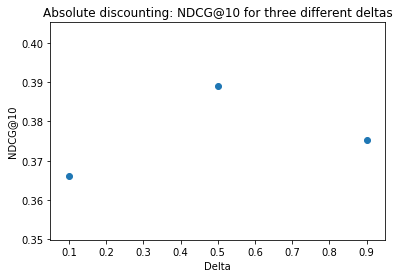

In [197]:
absdisc_ndcg = [0.3662, 0.3889, 0.3754]
absdisc_delta = [1, 5, 9]
plt.scatter(absdisc_lamb, absdisc_ndcg)
plt.xlabel('Delta')
plt.ylabel('NDCG@10')
plt.title('Absolute discounting: NDCG@10 for three different deltas')
plt.show()

In [ ]:
jelimerc_ndcg = [0.0504,0.0504,0.0504]
jelimerc_lambda = [1,5,9]

plt.scatter(jelimerc_lambda,jelimerc_ndcg)
plt.xlabel('Lambda')
plt.ylabel('NDCG@10')
plt.title('Jellinek-Mercer: NDCG@10 for three different lambdas')
plt.show()

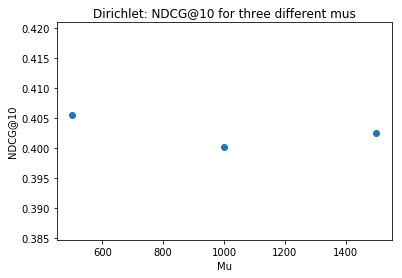

In [199]:
dirismooth_ndcg = [0.4055,0.4002,0.4026]
dirismooth_mu = [500,1000,1500]

plt.scatter(dirismooth_mu, dirismooth_ndcg)
plt.xlabel('Mu')
plt.ylabel('NDCG@10')
plt.title('Dirichlet: NDCG@10 for three different mus')
plt.show()

### Now run the language models again with their optimal parameters on the test set

In [200]:
# # run run_retrieval

# '''
# Jelinek-Mercer (explore different values of 𝛌 in the range [0.1, 0.5, 0.9]). [5 points]
# Dirichlet Prior (explore different values of 𝛍 [500, 1000, 1500]). [5 points]
# Absolute discounting (explore different values of 𝛅 in the range [0.1, 0.5, 0.9]). [5 points]
# '''

# best_smoothings_functions = [jelinek_01, dirichlet_500, absolute_05]

# import cProfile, pstats
# from io import StringIO
# pr = cProfile.Profile()
# pr.enable()

# for smoothing_func, label in best_smoothings_functions:
#     run_retrieval(label, 
#                   functools.partial(log_multinomial_query_language_model, word_probability_func=smoothing_func), 
#                   "Probabilistic", test_queries_ids)

# pr.disable()
# s = StringIO()
# sortby = 'cumulative'
# ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
# ps.print_stats()
# print(s.getvalue())

### The Positional based language model (PLM)
The PLM only has to be run on the top 1000 documents per query (ranked by the TF-IDF). We run it for all values of mu on the test queries instead of just for the mu of 1500. We do this to see if there might be a difference for this model or maybe if a subset is used. If a difference is found, we run the the other language models again, but just on these top-1000 queries


In [208]:
## Generate all PLM Values
PLM_GAUS_500 = (functools.partial(PLM_score_old, kernel_func = gaussian_kernel, mu = 500), 'PLM_Gaussian_500')
PLM_GAUS_1000 = (functools.partial(PLM_score_old, kernel_func = gaussian_kernel, mu = 1000), 'PLM_Gaussian_500')
PLM_GAUS_1500 = (functools.partial(PLM_score_old, kernel_func = gaussian_kernel, mu = 1500), 'PLM_Gaussian_500')

PLM_TRIANGLE_500 = (functools.partial(PLM_score_old, kernel_func = triangle_kernel, mu = 500), 'PLM_TRIANGLE_500')
PLM_TRIANGLE_1000 = (functools.partial(PLM_score_old, kernel_func = triangle_kernel, mu = 1000), 'PLM_TRIANGLE_1000')
PLM_TRIANGLE_1500 = (functools.partial(PLM_score_old, kernel_func = triangle_kernel, mu = 1500), 'PLM_TRIANGLE_1500')

PLM_COSINE_500 = (functools.partial(PLM_score_old, kernel_func = cosine_kernel, mu = 500), 'PLM_COSINE_500')
PLM_COSINE_1000 = (functools.partial(PLM_score_old, kernel_func = cosine_kernel, mu = 1000), 'PLM_COSINE_1000')
PLM_COSINE_1500 = (functools.partial(PLM_score_old, kernel_func = cosine_kernel, mu = 1500), 'PLM_COSINE_1500')

PLM_CIRCLE_500 = (functools.partial(PLM_score_old, kernel_func = circle_kernel, mu = 500), 'PLM_CIRCLE_500')
PLM_CIRCLE_1000 = (functools.partial(PLM_score_old, kernel_func = circle_kernel, mu = 1000), 'PLM_CIRCLE_1000')
PLM_CIRCLE_1500 = (functools.partial(PLM_score_old, kernel_func = circle_kernel, mu = 1500), 'PLM_CIRCLE_1500')

PLM_PASSAGE_500 = (functools.partial(PLM_score_old, kernel_func = passage_kernel, mu = 500), 'PLM_PASSAGE_500')
PLM_PASSAGE_1000 = (functools.partial(PLM_score_old, kernel_func = passage_kernel, mu = 1000), 'PLM_PASSAGE_1000')
PLM_PASSAGE_1500 = (functools.partial(PLM_score_old, kernel_func = passage_kernel, mu = 1500), 'PLM_PASSAGE_1500')


smoothings_functions = [PLM_PASSAGE_500, PLM_PASSAGE_1000, PLM_PASSAGE_1500,
                        PLM_TRIANGLE_500,PLM_TRIANGLE_1000,PLM_TRIANGLE_1500,
                        PLM_COSINE_500, PLM_COSINE_1000, PLM_COSINE_1500,
                        PLM_CIRCLE_500,PLM_CIRCLE_1000,PLM_CIRCLE_1500,
                        PLM_PASSAGE_500,PLM_PASSAGE_1000,PLM_PASSAGE_1500]

for smoothing_func, label in smoothings_functions:
    run_retrieval(label, 
                  functools.partial(log_multinomial_query_language_model, word_probability_func=smoothing_func), 
                  "Probabilistic", test_queries_ids)


Retrieving using PLM_PASSAGE_500
[5872, 3066]
log mulitnomial query_terms and document id [5872, 3066] 29


TypeError: 'int' object is not iterable

### Task 2: Latent Semantic Models (LSMs) [15 points] ###

In this task you will experiment with applying distributional semantics methods ([LSI](http://lsa3.colorado.edu/papers/JASIS.lsi.90.pdf) **[5 points]** and [LDA](https://www.cs.princeton.edu/~blei/papers/BleiNgJordan2003.pdf) **[5 points]**) for retrieval.

You do not need to implement LSI or LDA on your own. Instead, you can use [gensim](http://radimrehurek.com/gensim/index.html). An example on how to integrate Pyndri with Gensim for word2vec can be found [here](https://github.com/cvangysel/pyndri/blob/master/examples/word2vec.py). For the remaining latent vector space models, you will need to implement connector classes (such as `IndriSentences`) by yourself.

In order to use a latent semantic model for retrieval, you need to:
   * build a representation of the query **q**,
   * build a representation of the document **d**,
   * calculate the similarity between **q** and **d** (e.g., cosine similarity, KL-divergence).
     
The exact implementation here depends on the latent semantic model you are using. 
   
Each of these LSMs come with various hyperparameters to tune. Make a choice on the parameters, and explicitly mention the reasons that led you to these decisions. You can use the validation set to optimize hyper parameters you see fit; motivate your decisions. In addition, mention clearly how the query/document representations were constructed for each LSM and explain your choices.

In this experiment, you will first obtain an initial top-1000 ranking for each query using TF-IDF in **Task 1**, and then re-rank the documents using the LSMs. Use TREC Eval to obtain the results and report on `NDCG@10`, Mean Average Precision (`MAP@1000`), `Precision@5` and `Recall@1000`.

Perform significance testing **[5 points]** (similar as in Task 1) in the class of semantic matching methods.

In [48]:
import gensim.models
import gensim
    
# Under construction:
def LSI(corpus, dictionary, num_topics):
    return gensim.models.lsimodel.LsiModel(corpus, id2word=dictionary, num_topics=num_topics)

# Pending:
def LDA(arg1, arg2):
    return gensim.models.ldamodel.LdaModel(corpus=sentences, id2word=words, num_topics=10)

In [49]:
# This is the connector that ports Pyndri objects in a Gensim-friendly way.
# Source: http://www.pythonexample.com/code/gensim-pyro/
# Only updated return values from _doc2bow func; swapped key, value

class LDALSISentences(gensim.interfaces.CorpusABC):
    # Dictionary through task 2 = vocabulary
    def __init__(self, index, dictionary, max_documents=None):
        assert isinstance(index, pyndri.Index)
 
        self.index = index
        self.dictionary = dictionary
 
        self.max_documents = max_documents
 
    def _maximum_document(self):
        if self.max_documents is None:
            return self.index.maximum_document()
        else:
            return min(
                self.max_documents + self.index.document_base(),
                self.index.maximum_document())
 
    def _doc2bow(self, doc):
 
        di = collections.defaultdict(int)
 
        for token_id in doc:
            di[token_id] += 1
    
        return [(key, value) for key, value in di.items()]
 
    def __iter__(self):

        for int_doc_id in range(self.index.document_base(),
                                self._maximum_document()):
            ext_doc_id, tokens = self.index.document(int_doc_id)
 
            tokens = tuple(
                token_id
                for token_id in tokens
                if token_id > 0 and token_id in self.dictionary)

            yield self._doc2bow(tokens)
 
    def __len__(self):
        return self._maximum_document() - self.index.document_base()

In [50]:
import gensim.models

    
def LSI(corpus, dictionary, num_topics, store=False):
    
    lsi = gensim.models.lsimodel.LsiModel(corpus, id2word=dictionary, num_topics=num_topics)
    
    if store == True:
        file_name = ""
        full_file_name = file_name + ".p"
        
        if full_file_name.exists():
            print("This file already exists, pick another...")
            return
        
        pickle.dump(lsi, open(full_file_name, "wb"))
        
    return lsi


def LDA(corpus, dictionary, num_topics, update_every=1, chunksize=1000, passes=1, store=False):
    
    print("Start training LDA model...")
    lda = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                          id2word=dictionary, 
                                          num_topics=num_topics, 
                                          update_every=update_every, 
                                          chunksize=chunksize, 
                                          passes=passes)
    
    print("Done training")
    
    if store == True:
        file_name = "lda_model_tfidf100"
        full_file_name = file_name + ".p"
        
        if full_file_name.exists():
            print("This file already exists, pick another...")
            return
        
        try:    
            pickle.dump(lda, open(full_file_name, "wb" ))
        except:
            print("Storing LDA model failed...")
        
    return lda
    
def print_model_topics(model, nr_of_topics, words_per_topic):
    print(model.print_topics(nr_of_topics, num_words=words_per_topic))
    return

In [51]:
# Import dependencies:
import gensim
import pickle
from scipy.sparse import dok_matrix
from scipy import spatial

# Step 0: Convert corpus into gensim dictionary object
def init_corpus(store=False):
    
    #index = pyndri.Index('index/')
    print("Building dictionary...")
    dictionary = pyndri.extract_dictionary(index)
    
    print("Building corpus...")
    corpus = LDALSISentences(index, dictionary)
    
    # For our own TF IDF, skip those doc ids that are not in given list.
    print("Building TF-Corpus...")
    corpus = [doc for doc in corpus]
    
    print("Storing dictionary and corpus...")
    
    if store == True:
        pickle.dump(dictionary, open( "dictionary.p", "wb" ))
        pickle.dump(corpus, open( "corpus_tf.p", "wb" ))
    
    return corpus, dictionary

# Create our own TFIDF corpus based on task 1
def transform_corpus(corpus, store=False):
    print("Initializing TFIDF model...")
    tfidf_model = gensim.models.TfidfModel(corpus)
    
    print("Training TFIDF model...")
    corpus_tfidf = tfidf_model[corpus]
    
    if store == True:
        pickle.dump(corpus_tfidf, open( "corpus_tfidf.p", "wb" ))
    
    return corpus_tfidf

def load_from_pickle(corp_bow="", q_bow="", sem_model="", sim_model=""):
    
    corpus_bow, query_bows, semantic_model, similarity_model = None, None, None, None
    
    if corp_bow != "":
        try:
            print("Loading corpus BOW: %s...".format(corp_bow))
            with open(corp_bow, 'rb') as f:
                corpus_bow = pickle.load(f)
            print("Load successful")
        except:
            print("Load unsuccesful")
            
    if q_bow != "":
        try:
            print("Loading query BOW: %s...".format(q_bow))
            with open(q_bow, 'rb') as f:
                query_bows = pickle.load(f)
            print("Load successful")
        except:
            print("Load unsuccessful")
    
    if sem_model != "":
        try:
            print("Loading semantic model: %s...".format(sem_model))
            with open(sem_model, 'rb') as f:
                semantic_model = pickle.load(f)
            print("Load successful")
        except:
            print("Load unsuccessful")
        
    if sim_model != "":
        try:
            print("Loading similarity model: %s...".format(sim_model))
            with open(sem_model, 'rb') as f:
                similarity_model = pickle.load(f)
            print("Load successful")
        except:
            print("Load unsuccessful")
        
    return corpus_bow, query_bows, semantic_model, similarity_model


# Step 1: Build a representation q of the query
def query_representation(dictionary):
    
    with open('./ap_88_89/topics_title', 'r') as f_topics:
        queries = parse_topics([f_topics])
        
    tokenized_queries = {
        query_id: [dictionary.translate_token(token)
                   for token in index.tokenize(query_string)
                   if dictionary.has_token(token)]
        for query_id, query_string in queries.items()}

    unique_query_ids = set(
        query_term_id
        for query_term_ids in tokenized_queries.values()
        for query_term_id in query_term_ids)
    
    query_bows = [dictionary.doc2bow(query)
                  for query in tokenized_queries.values()]
    
    return tokenized_queries, unique_query_ids, query_bows

# Step 2: Build a representation d of the documents i.e. by scoring them
def document_representation(index, dictionary, method="tfidf"):
    """ Returns a documents representation; """
    X = dok_matrix((len(dictionary), len(index) + 1), dtype=np.float32)
    start_time = time.time()
    # TODO: You only care about words occurring in the query, since otherwise IF-IDF == 0 (?)

    if method == "tfidf":
        for query_id in inverted_index.keys():
            for doc_id in inverted_index[query_id]:
                X[query_id, doc_id] = tfidf(doc_id, query_id)

    elif method == "tf":
        for query_id in inverted_index.keys():
            for doc_id in inverted_index[query_id]:
                X[query_id, doc_id] = term_frequency(query_id, doc_id)
    
    return X

# Step 3: Build a function that is able to calculate similarity between q and d.
def cosine_similarity(vector_a, vector_b):
    
    #vector_a = X[:,1].toarray().flatten()
    #vector_b = X[:,2].toarray().flatten()
    
    return 1 - spatial.distance.cosine(vector_a, vector_b)

def init_similarity_model(model, corpus, num_features=300, store=False):
    
    sim_index = gensim.similarities.MatrixSimilarity(model[corpus], num_features=num_features)
    
    if store == True:
        pickle.dump(sim_index, open("sim_index_lsi_tf.p", "wb"))
    
    return sim_model
    
# Generates a weird error:
def gensim_cosine_similarity(sim_model, model, query_bow, top_num=10):
    
    query_representation = model[query_bow]
    
    similarities = sim_model[query_representation]
    
    sorted_similarities = sorted(enumerate(similarities), key=lambda item: -item[1])
    
    results = sorted_similarities[:top_n]

    return similarities

# Step 4: Use the representations to train LSMs - choose hyperparams by testing

# Step 5: Use TF-IDF to rank top 1000 documents, for each query

# Step 6: Use both LSMs to re-rank top 1000 documents and apply TREC to test results. Based on:
## - NDCG@10
## - MAP@1000
## - Precision@5
## - Recall@1000

#corpus_tfidf, _, _, _ = load_from_pickle(corp_bow="corpus_tfidf.p")

In [52]:
corpus_tfidf, _ = init_corpus()

# query_bow = query_bows[27]

# print(len(query_bow))

# query_lsi = lsi_model_tfidf[query_bow]

# similarities = sim_index_lsi_tfidf[query_lsi]

# print(len(similarities))

# sorted_similarities = sorted(enumerate(similarities), key=lambda item: -item[1])

# top_n = 1000

# results = sorted_similarities[:top_n]

# print(results)

Building dictionary...
Building corpus...
Building TF-Corpus...
Storing dictionary and corpus...


### Task 3:  Word embeddings for ranking [20 points] (open-ended) ###

First create word embeddings on the corpus we provided using [word2vec](http://arxiv.org/abs/1411.2738) -- [gensim implementation](https://radimrehurek.com/gensim/models/word2vec.html). You should extract the indexed documents using pyndri and provide them to gensim for training a model (see example [here](https://github.com/nickvosk/pyndri/blob/master/examples/word2vec.py)).
   
This is an open-ended task. It is left up you to decide how you will combine word embeddings to derive query and document representations. Note that since we provide the implementation for training word2vec, you will be graded based on your creativity on combining word embeddings for building query and document representations.

Note: If you want to experiment with pre-trained word embeddings on a different corpus, you can use the word embeddings we provide alongside the assignment (./data/reduced_vectors_google.txt.tar.gz). These are the [google word2vec word embeddings](https://code.google.com/archive/p/word2vec/), reduced to only the words that appear in the document collection we use in this assignment.

In [55]:
import pyndri.compat
import copy

word2vec = gensim.models.Word2Vec(
    size=300,  # Embedding size
    window=5,  # One-sided window size
    sg=True,  # Skip-gram.
    min_count=5,  # Minimum word frequency.
    sample=1e-3,  # Sub-sample threshold.
    hs=False,  # Hierarchical softmax.
    negative=10,  # Number of negative examples.
    iter=1,  # Number of iterations.
    workers=8,  # Number of workers.
)

dictionary = pyndri.extract_dictionary(index)
sentences = pyndri.compat.IndriSentences(index, dictionary)

%time word2vec.build_vocab(sentences, trim_rule=None)

w2v_models = [word2vec]

N_EPOCHS = 1

for epoch in range(N_EPOCHS):
    print('Epoch ', epoch)

    w2v_model = copy.deepcopy(w2v_models[-1])
    w2v_model.train(sentences, total_examples=word2vec.corpus_count, epochs=1)

    w2v_models.append(w2v_model)



CPU times: user 1min 26s, sys: 2.86 s, total: 1min 29s
Wall time: 1min 31s
Epoch  0


KeyboardInterrupt: 

In [124]:
pickle.dump(lda_model_tfidf, open("lda_model_tfidf100.p", "wb"))

### Task 4: Learning to rank (LTR) [15 points] (open-ended) ###

In this task you will get an introduction into learning to rank for information retrieval.

You can explore different ways for devising features for the model. Obviously, you can use the retrieval methods you implemented in Task 1, Task 2 and Task 3 as features. Think about other features you can use (e.g. query/document length). Creativity on devising new features and providing motivation for them will be taken into account when grading.

For every query, first create a document candidate set using the top-1000 documents using TF-IDF, and subsequently compute features given a query and a document. Note that the feature values of different retrieval methods are likely to be distributed differently.

You are adviced to start some pointwise learning to rank algorithm e.g. logistic regression, implemented in [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).
Train your LTR model using 10-fold cross validation on the test set. More advanced learning to rank algorithms will be appreciated when grading.

In [176]:
# Possible features:
# - Query/Document Feature
#  - TF/IDF
#  - BM25
#  - PLM-score
#   - Positie van PLM score in het document
#  - a Language Model
#  - Topical matching
#  - Correlation of relevance matrix?
# - Document Features
#  - Document Length
# - Query Features
#  - Presence of given name in query
#  - Query Length

# Normalization:
# We compute all the features and then scale to zero-mean and unit variance
# Can be done with StandardScaler from scikit learn.
# For D/Q features: read from .run files
# Query level feature normalization is needed

# MACHINE LEARNING

# Computing Loss:
# Read from ap_88_89/qrel_*

from sklearn.preprocessing import normalize

def read_run(path_to_run):
    '''
    Read document scores from a .run file
    
    :param path_to_run: where to find the .run file
    '''
    
    scores = defaultdict(dict)
    
    with open(path_to_run) as run_file:
        for i, line in enumerate(run_file.readlines()):
            query_id, _, ext_doc_id, document_rank, score, label = line.split()
            
            # Skip q/d pairs that don't share words
            if score == '0' or score == '-inf':
                continue
                
            scores[int(query_id)][ext2int[ext_doc_id]] = float(score)
            
    return matrix_from_two_level_dict(scores)
    
def build_relevance_matrix(path_to_relavance_labels = 'ap_88_89/qrel_validation'):
    '''
    Constructs a sparse matrix where the relevant query/document pairs are 1's and the rest 0's
    
    :param path_to_relevance_labels: where to find the relevance file
    '''
    
    relevance_labels_validation = defaultdict(dict)

    # Read from relevance file
    with open(path_to_relavance_labels) as valid_file:
        for i, line in enumerate(valid_file.readlines()):
            query_id, _, ext_doc_id, relevance = line.split()
            relevance_labels_validation[int(query_id)][ext2int[ext_doc_id]] = int(relevance)

    return matrix_from_two_level_dict(relevance_labels_validation)

def matrix_from_two_level_dict(dictionary):
    
    matrix = np.zeros((max(dictionary.keys()) + 1, len(ext2int)))
    
    print("Matrix size: ", matrix.shape)
    
    for key, sub_dict in dictionary.items():
        for sub_key, value in sub_dict.items():
            matrix[key, sub_key] = value
            
    return matrix #.tocsr()

def normalize_log_probs(matrix):
    real_probs = np.exp(matrix)
#     return real_probs
    return normalize(real_probs)

def preprocess_features(run_dir):
    '''Build a matrix based on features for all documents and queries'''
    
    def is_validation_run(file_name):
        return '.run' in file_name and 'test' not in file_name and 'TF' not in file_name

    run_file_names = ["{}/{}".format(run_dir,file_name) for file_name in os.listdir(run_dir) 
                      if is_validation_run(file_name)]

    features_per_pair = [read_run(file_name) for file_name in run_file_names]
    normalized_feat_per_pair = [normalize_log_probs(matrix) for matrix in features_per_pair]
    
    n_features = len(features_per_pair)
    n_queries = features_per_pair[0].shape[0]
    n_docs = features_per_pair[0].shape[1]

    features = np.concatenate(normalized_feat_per_pair, axis=0).reshape(n_features, n_queries, n_docs)

    return np.transpose(features, (1, 2, 0))

def learn_ranking(features, relevance_labels):
    

Matrix size:  (193, 164630)
Matrix size:  (193, 164630)
Matrix size:  (193, 164630)
Matrix size:  (193, 164630)
Matrix size:  (193, 164630)
Matrix size:  (193, 164630)
Matrix size:  (193, 164630)
Matrix size:  (193, 164630)
Matrix size:  (193, 164630)


In [178]:


assert transposed_features.shape == (n_queries, n_docs, n_features)



CPU times: user 875 ms, sys: 3.72 s, total: 4.59 s
Wall time: 5.9 s


array([ 0.00570932,  0.00704123,  0.00837314,  0.00862766,  0.0086518 ,
        0.00856489,  0.0078355 ,  0.00435306,  0.00087061])

### Task 4: Write a report [15 points; instant FAIL if not provided] ###

The report should be a PDF file created using the [sigconf ACM template](https://www.acm.org/publications/proceedings-template) and will determine a significant part of your grade.

   * It should explain what you have implemented, motivate your experiments and detail what you expect to learn from them. **[10 points]**
   * Lastly, provide a convincing analysis of your results and conclude the report accordingly. **[10 points]**
      * Do all methods perform similarly on all queries? Why?
      * Is there a single retrieval model that outperforms all other retrieval models (i.e., silver bullet)?
      * ...

**Hand in the report and your self-contained implementation source files.** Only send us the files that matter, organized in a well-documented zip/tgz file with clear instructions on how to reproduce your results. That is, we want to be able to regenerate all your results with minimal effort. You can assume that the index and ground-truth information is present in the same file structure as the one we have provided.
